In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import community
import markov_clustering as markov
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy import sparse
from wordcloud import WordCloud
from modules.network import get_degree

# Get default colors
colors = [*mcolors.TABLEAU_COLORS.values()]

%matplotlib inline

In [2]:
# Define periods under analysis
years = [2017, 2018]

In [3]:
# Load dictionaries mapping indices to lemma tuples
w2i = np.load('data/edges_w2i.npy', allow_pickle=True).item()
i2w = np.load('data/edges_i2w.npy', allow_pickle=True).item()

In [4]:
# Load connected componets
connected_components = np.load('data/connected_components.npy', allow_pickle=True).item()

In [5]:
# Load edges
edges = pd.read_csv('data/database/edges.csv')
edges = {y: edges[edges.year == y][['node_x', 'node_y', 'weight']] for y in years}

In [6]:
# Check edges 2017
edges[2017].head()

node_x  node_y  weight
0       0     654       1
1       0    2466       1
2       0    2469       1
3       4     210       1
4       4    1076       1

In [7]:
# Check edges 2018
edges[2018].head()

node_x  node_y  weight
25278       1     227       1
25279       1     323       1
25280       1     772       1
25281       1    1000       1
25282       1    1429       1

In [8]:
# Create undirected weighted graph objects using edges table
networks = {}
for y in years:
    networks[y] = nx.from_pandas_edgelist(edges[y], source='node_x', target='node_y', 
                                          edge_attr=True, create_using=nx.MultiGraph)

In [9]:
# Define colors and labels for each POS tag
pos_patches = {
    'N': (colors[0], 'Noun'),  # Noun
    'V': (colors[1], 'Verb'),  # Verb
    'A': (colors[2], 'Adjective'),  # Adjective
    'R': (colors[3], 'Adverb')   # Adverb
}

# Define function for plotting cluster wordcloud
def make_word_cloud(word_cloud, scores):
    """
    Input:
    - Lemmas: list of tuples (word text, pos tag)
    - Scores: list of scores which define word importance
    Note that len(scores) = len(lemmas) must be satisfied
    Output:
    - WordCloud object
    """
    
    # Use words only to define word positions
    word_cloud = word_cloud.generate_from_frequencies(
        {word_text: score for (word_text, pos_tag), score in scores.items()}
    )
    
    # Modify layout
    for i, (word, font_size, position, orientation, color) in enumerate(word_cloud.layout_):
        # Get text and pos tag, separated
        pos_tag = scores.index[i][1]
        word_cloud.layout_[i] = (word, font_size, position, orientation, pos_patches[pos_tag][0])
    
    # Return modified wordcloud object
    return word_cloud

# Markov clustering

In [10]:
# MCL parameters

# Inflaction: float > 1
imin = 15       # minimum inflaction * 10
imax = 40       # maximum inflaction * 10
istep = 5       # step for inflaction exploration * 10

# Expansion: integer > 1
emin = 2        # minimum expansion 
emax = 8        # maximum expansion 
estep = 1       # step for expansion exploration

max_iter = 500  # max number of iterations for the algorithm

In [11]:
# Evaluate modularity for each set of parameters

# for k in adj_matrices.keys():
#    # convert the matrix to sparse
#    mat = sparse.csr_matrix(adj_matrices[k])
#    print('{:s}\'s network'.format(k))
#    # Grid search for best parameters
#    for inf in [i / 10 for i in range(imin, imax, istep)]:
#        for exp in [e for e in range(emin, emax, estep)]:
#            # Compute clusters
#            result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp) 
#            clusters = markov.get_clusters(mat) 
#            print("Num. clusters:",len(clusters))
#            # Compute corresponding modularity
#            Q = markov.modularity(matrix=result, clusters=clusters)
#            print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [12]:
# Second evaluation: only on 2018 net
#
# print('\n\n2018\'s network')
# # convert the matrix to sparse
# mat = sparse.csr_matrix(X[1])
# exp = 2
# inf_range = [40, 120]
# for inf in [i/10 for i in range(inf_range[0], inf_range[1], 10)]:
#    # Compute clusters
#    result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp ) 
#    clusters = markov.get_clusters(mat) 
#    print("Num. clusters:",len(clusters))
#    # Compute corresponding modularity
#    Q = markov.modularity(matrix=result, clusters=clusters)
#    print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [13]:
# Best parameters
params = {
    2017: {'inf': 1.5, 'exp': 4},  # mod = 0.0011712948963333333, n. clusters 48
    2018: {'inf': 3.5, 'exp': 2}   # mod = 0.023 (?) , n. clusters 112
}

In [14]:
# Compute Markov clusters

# Define clusters container: each cluster contains a list of nodes
mcl_clusters = {}

for y in years:
    # Define the subgraph of the giant component only
    giant_component = nx.induced_subgraph(networks[y], connected_components[y][0]['component'])
    # Retrieve adjacency matrix
    adj_matrix = nx.to_pandas_adjacency(giant_component, weight='weight')
    # Convert the matrix to sparse
    adj_matrix_val = sparse.csr_matrix(adj_matrix.values)
    # Setup running Markov Clustering using best parameters
    markov.run_mcl(adj_matrix_val, verbose=1, pruning_threshold=0, iterations=max_iter, 
                   inflation=params[y]['inf'], expansion=params[y]['exp']) 
    # Retrieve clusters according to dimension
    clusters = sorted(markov.get_clusters(adj_matrix_val), key=len, reverse=True)
    # Map matrix indices into words indices
    clusters = [ list(adj_matrix.index[list(c)].values) for c in clusters ]
    # Save clusters
    mcl_clusters[y] = clusters
    
# Save clusters to disk
np.save('data/mcl_clusters.npy', mcl_clusters)

--------------------------------------------------
MCL Parameters
Expansion: 4
Inflation: 1.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Checking for convergence
Iteration 5
Checking for convergence
Iteration 6
Checking for convergence
Iteration 7
Checking for convergence
Iteration 8
Checking for convergence
Converged after 8 iterations
--------------------------------------------------
--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 3.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Checking for convergence
Iteration 5
Chec

In [15]:
# Load Markov clusters from disk
mcl_clusters = np.load('data/mcl_clusters.npy', allow_pickle=True).item()

## Exploratory analysis

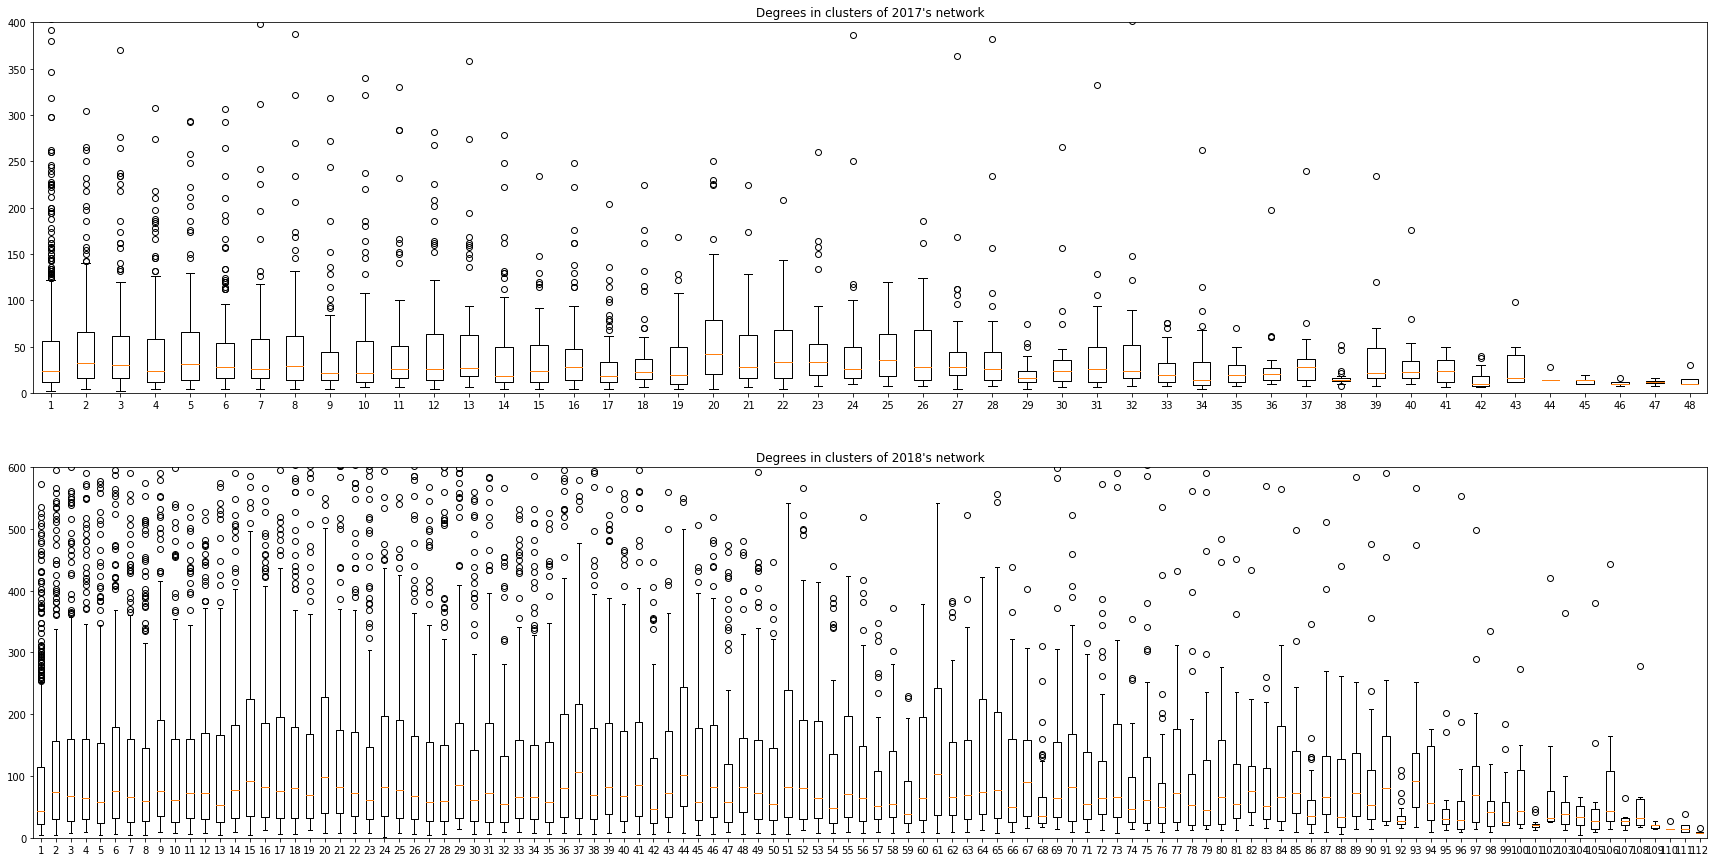

In [71]:
# Plot clusters degree distribution
fig, axs = plt.subplots(2, 1, figsize=(30, 15))

# Fill histograms
for i, y in enumerate(years):
    clusters = mcl_clusters[y].copy()
    for j, cluster in enumerate(clusters):
        subgraph = nx.induced_subgraph(networks[y], cluster)
        clusters[j] = get_degree(subgraph).tolist()
    _ = axs[i].set_title('Degrees in clusters of {:d}\'s network'.format(y))
    _ = axs[i].boxplot(clusters)
    
# Set axis bounds
_ = axs[0].set_ylim(0, 400)
_ = axs[1].set_ylim(0, 600)
_ = plt.show()

## Communities analysis

In [17]:
# Define number of clusters and nodes per clusters which must be shown for every cluster
num_clusters = 4
num_nodes = 20

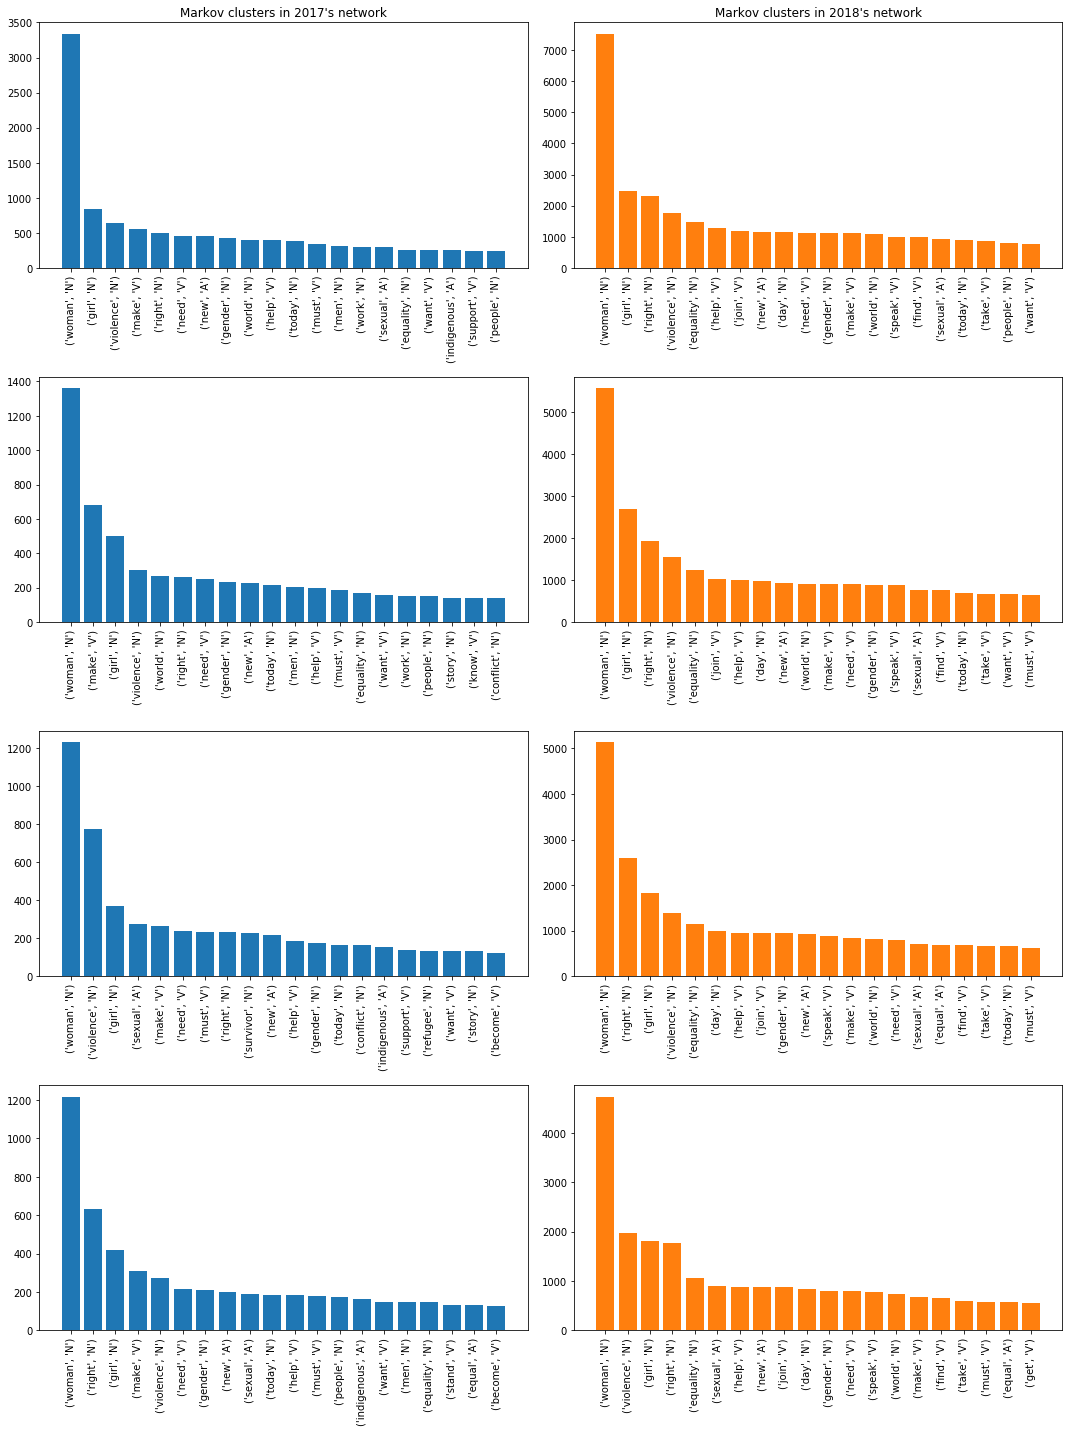

In [18]:
# Show histograms for Markov clusters

# Initialize plot
fig, axs = plt.sub
plots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Markov clusters in 2017\'s network')
_ = axs[0, 1].set_title('Markov clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(mcl_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree[:num_nodes]
        # Plot histograms
        _ = axs[j, i].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values, color=colors[i])
        _ = axs[j, i].tick_params(axis='x', labelrotation=90)

# Show plot
_ = plt.tight_layout()
_ = plt.show()

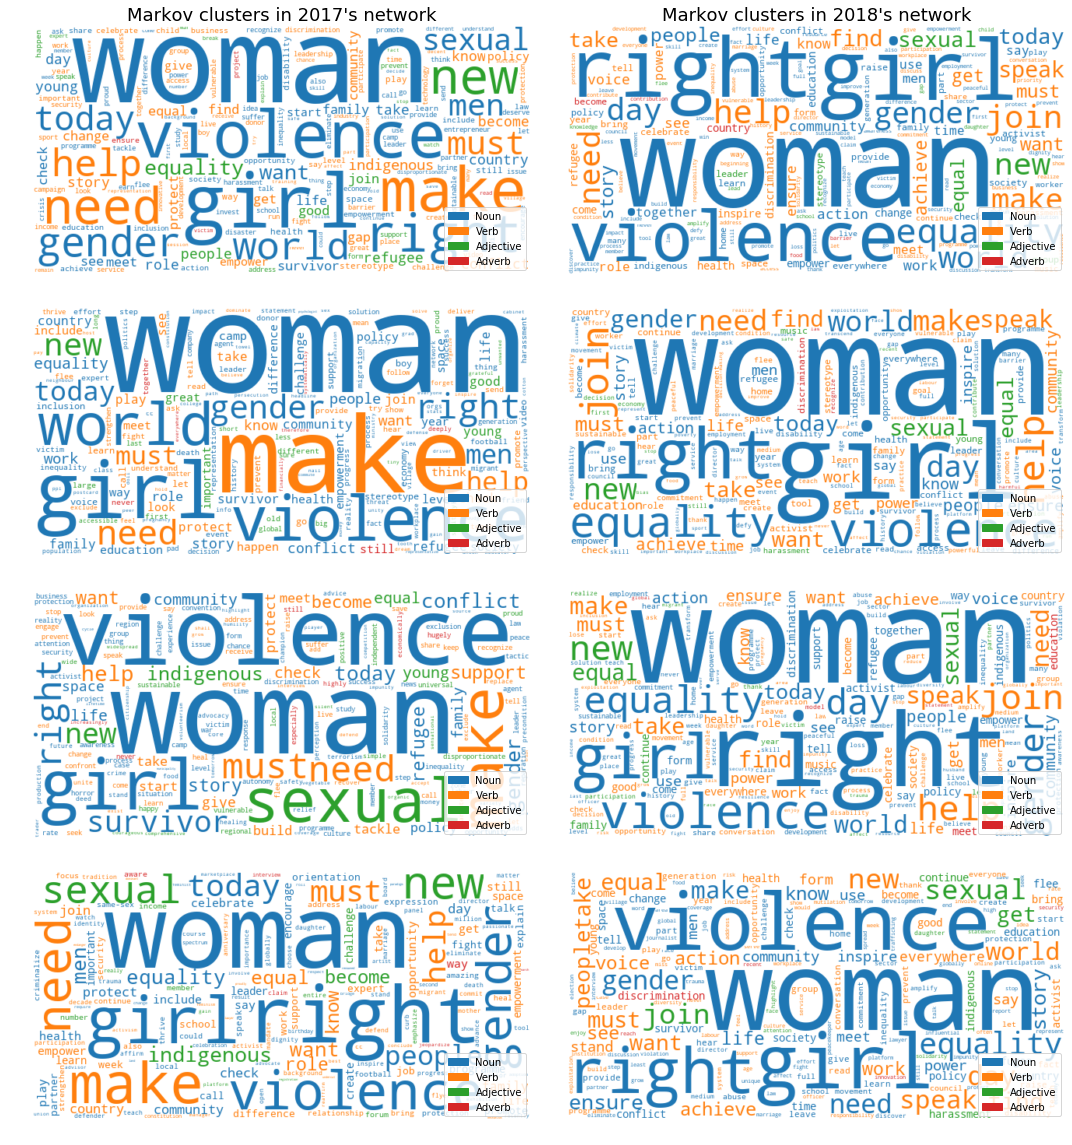

In [19]:
# Show wordclouds for Markov clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
_ = axs[0, 0].set_title('Markov clusters in 2017\'s network', size=18)
_ = axs[0, 1].set_title('Markov clusters in 2018\'s network', size=18)
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(mcl_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree / degree.sum()  # Scale degree
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(
            width=640, height=320, background_color='white'
        ), degree)
        # Plot wordclouds
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )

# Show plot
_ = plt.subplots_adjust(top=2.75)
_ = plt.tight_layout()
_ = plt.show()

In [20]:
# Save clusters to disk

# Define images width and height
img_width = 2040
img_height = 1080

# Print louvain clusters
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(mcl_clusters[y], key=len, reverse=True)
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        # Scale degree: use uniform distribution if every degree is zero
        degree = (degree / degree.sum()).fillna(1/degree.shape[0])
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(width=img_width, height=img_height, background_color='white'), degree)
        # Save to disk
        word_cloud.to_file('images/clusters/markov_by_degree/{:d}_{:d}.png'.format(y, j))


# Louvain clustering 

In [21]:
# Compute Louvain clusters
lou_clusters = {}

# For each year, fill a list of lists of nodes
for y in years:
    # Get the cluster as node -> cluster dictionary
    node_to_cluster = community.best_partition(networks[y].subgraph(connected_components[y][0]['component']))
    # Turn the cluster to a cluster -> [nodes] dictionary
    clusters = {}
    for node, cluster in node_to_cluster.items():
        # Fill cluster lists
        clusters.setdefault(cluster, []).append(node)
    # Store clusters
    lou_clusters[y] = list(clusters.values())
    
# Save clusters to disk
np.save('data/lou_clusters.npy', lou_clusters)

In [63]:
# Load louvain clusters from disk
lou_clusters = np.load('data/lou_clusters.npy', allow_pickle=True).item()

### Exploratory analysis

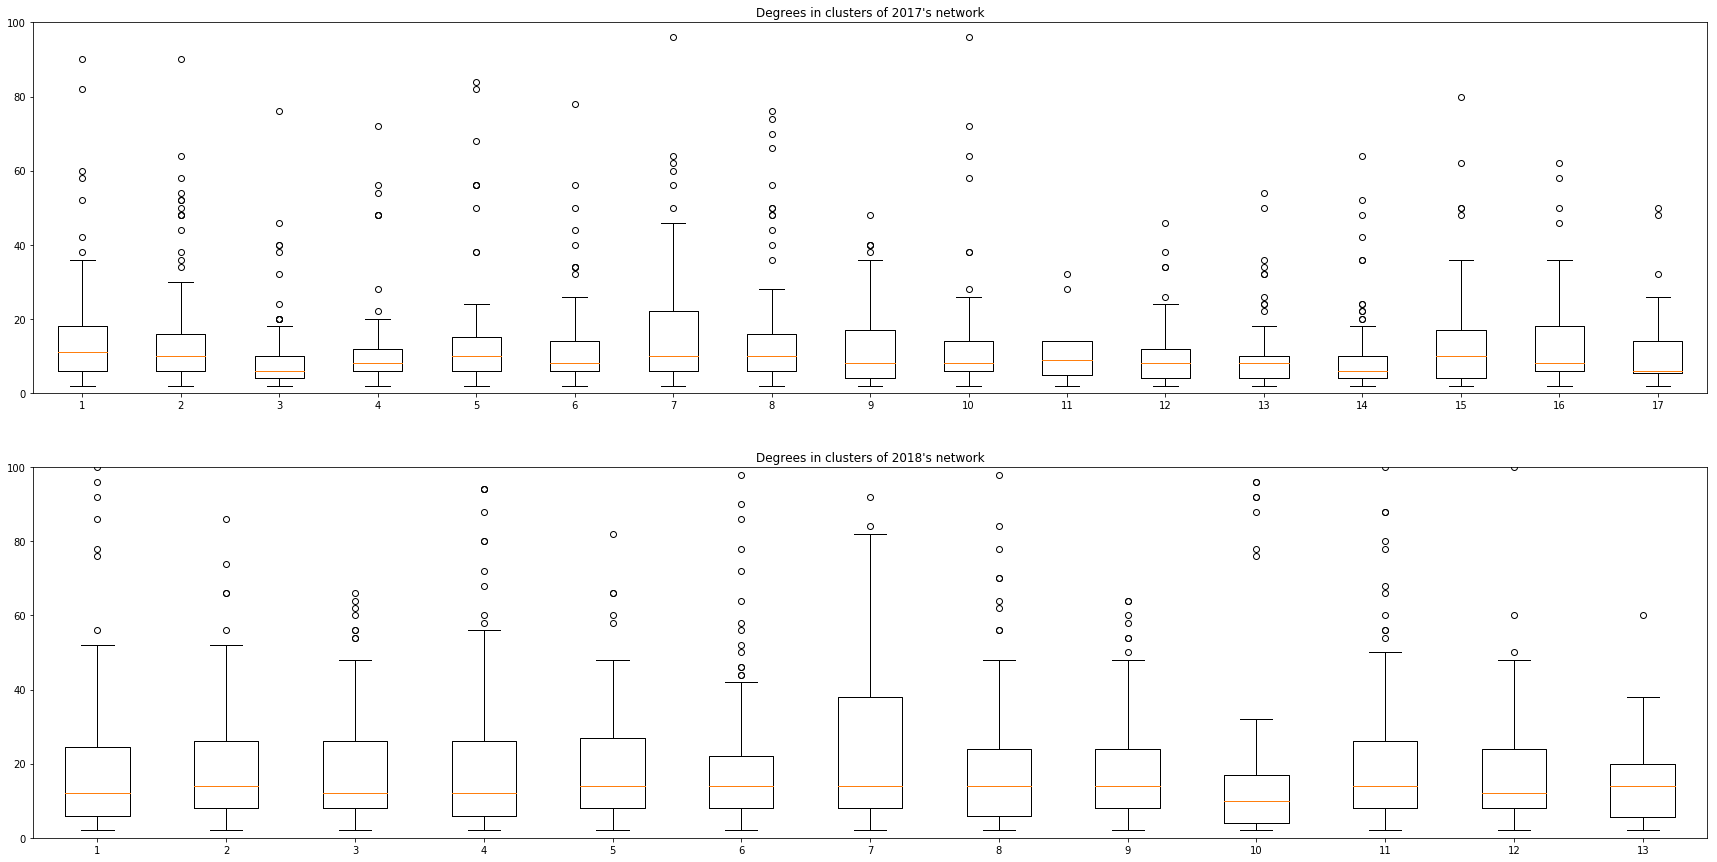

In [68]:
# Plot clusters degree distribution
fig, axs = plt.subplots(2, 1, figsize=(30, 15))

# Fill histograms
for i, y in enumerate(years):
    clusters = lou_clusters[y].copy()
    for j, cluster in enumerate(clusters):
        subgraph = nx.induced_subgraph(networks[y], cluster)
        clusters[j] = get_degree(subgraph).tolist()
    _ = axs[i].set_title('Degrees in clusters of {:d}\'s network'.format(y))
    _ = axs[i].boxplot(clusters)
    
# Set axis bounds
_ = axs[0].set_ylim(0, 100)
_ = axs[1].set_ylim(0, 100)
_ = plt.show()

### Communities analysis

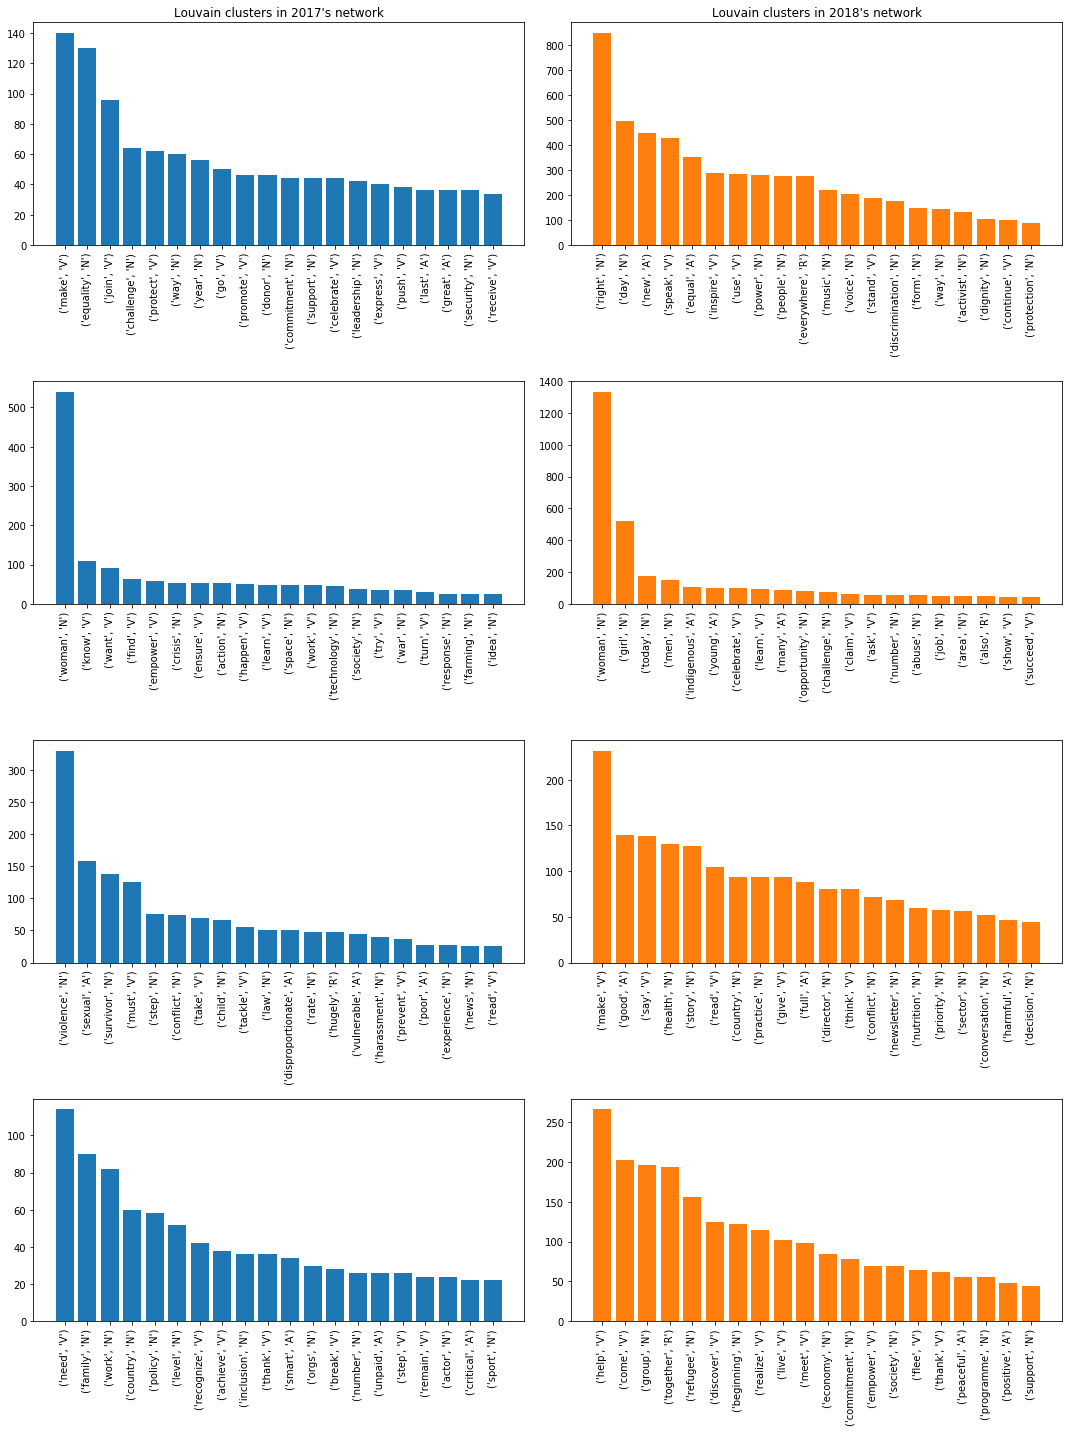

In [24]:
# Show histograms for Louvain clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Louvain clusters in 2017\'s network')
_ = axs[0, 1].set_title('Louvain clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(lou_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree[:num_nodes]
        # Plot histograms
        _ = axs[j, i].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values, color=colors[i])
        _ = axs[j, i].tick_params(axis='x', labelrotation=90)

# Show plot
_ = plt.tight_layout()
_ = plt.show()

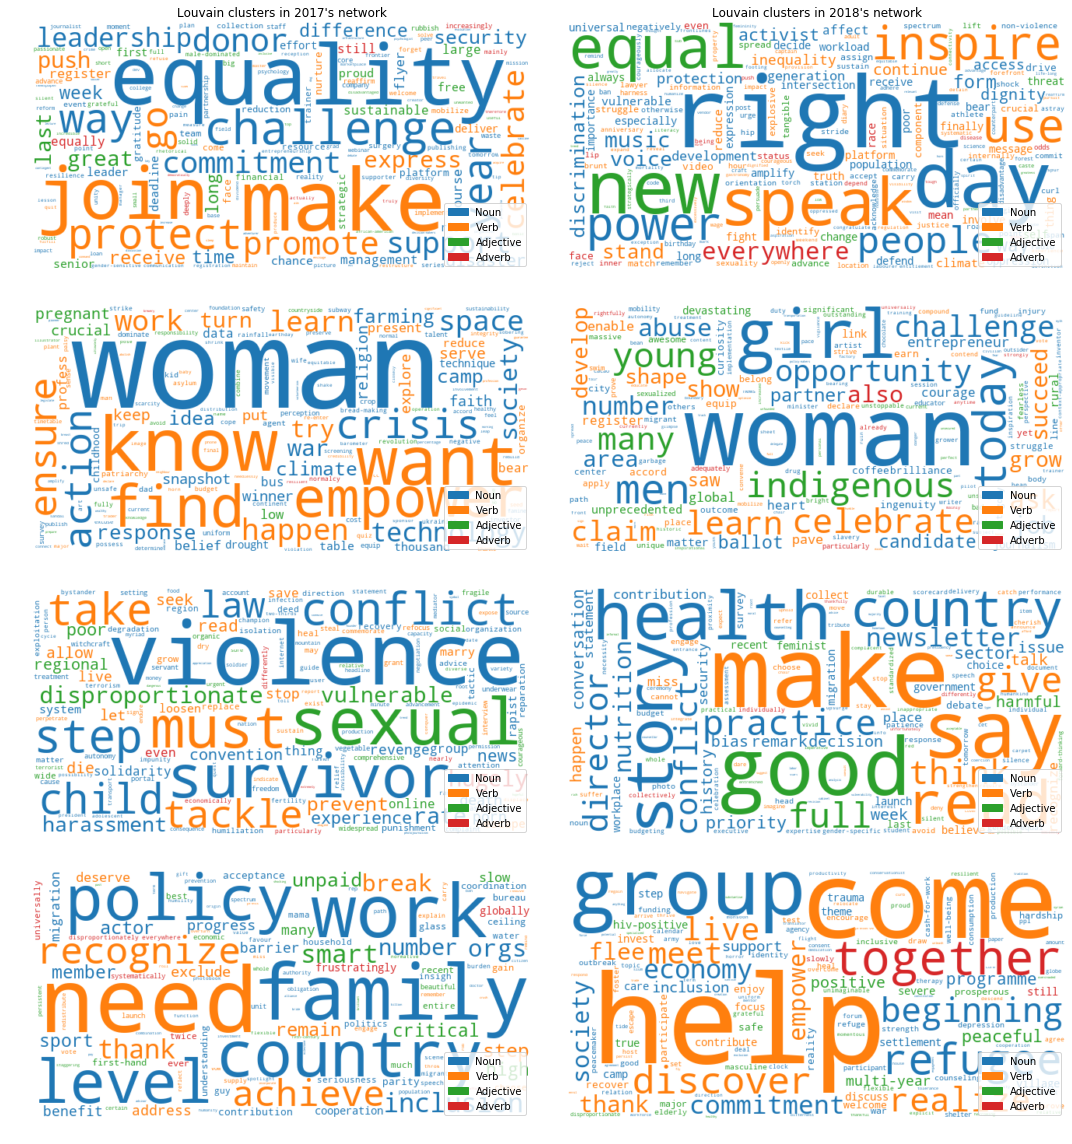

In [25]:
# Show wordclouds for Louvain clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Louvain clusters in 2017\'s network')
_ = axs[0, 1].set_title('Louvain clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(lou_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        # degree = degree[:num_nodes]
        degree = degree / degree.sum()  # Scale degree
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(
            width=640, height=320, background_color='white'
        ), degree)
        # Plot wordclouds
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )

# Show plot
_ = plt.subplots_adjust(top=1.75)
_ = plt.tight_layout()
_ = plt.show()

In [26]:
# Save clusters to disk

# Define images width and height
img_width = 2040
img_height = 1080

# Print louvain clusters
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(lou_clusters[y], key=len, reverse=True)
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree / degree.sum()  # Scale degree
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(width=img_width, height=img_height, background_color='white'), degree)
        # Save to disk
        word_cloud.to_file('images/clusters/louvain_by_degree/{:d}_{:d}.png'.format(y, j))

## Clusters selected by betweenness

In [27]:
# Load betweenness
betweenness = np.load('data/betweenness.npy', allow_pickle=True).item()

In [28]:
# Define louvain clusters with associated betweenness
clusters_btw = {}

# Compute and sort betweenness clusters using Louvain
for y in years:
    clusters_btw[y] = [(cluster, np.mean([betweenness[y][node] for node in cluster])) for cluster in lou_clusters[y]]
    clusters_btw[y] = sorted(clusters_btw[y], key=lambda x: x[1], reverse=True)
    # Turn each cluster in a Pandas series, mapping node to betweeness
    for j, cluster in enumerate(clusters_btw[y]):
        # Retrieve cluster as Pandas Series object
        cluster = pd.Series({i2w[node]: betweenness[y][node] for node in cluster[0]})
        cluster = cluster / cluster.sum()
        # Save cluster
        clusters_btw[y][j] = cluster

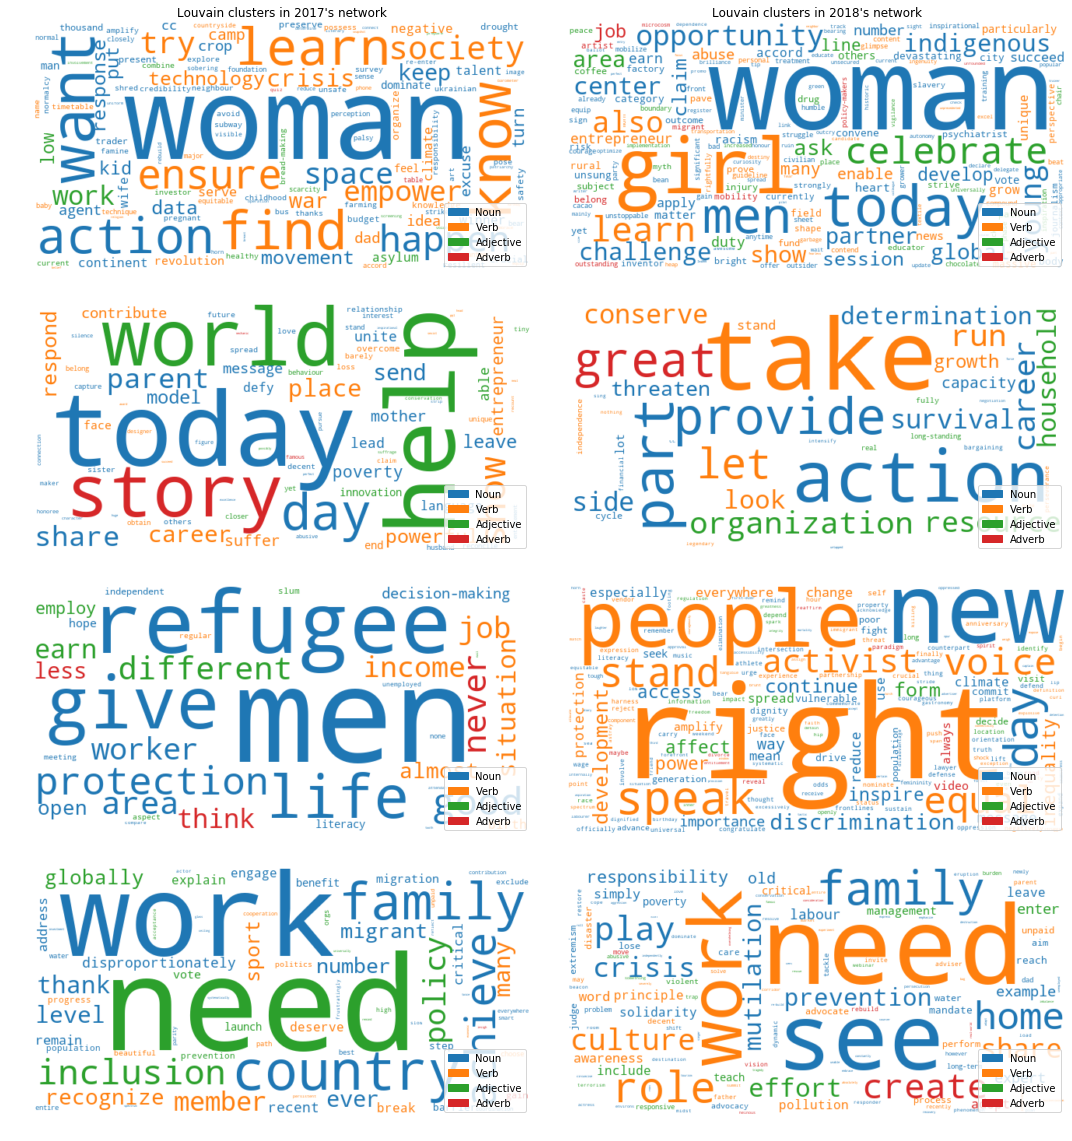

In [29]:
# Show wordclouds for Louvain clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
_ = axs[0, 0].set_title('Louvain clusters in 2017\'s network')
_ = axs[0, 1].set_title('Louvain clusters in 2018\'s network')

# Fill plots
for i, y in enumerate(years):
    # Plot every cluster
    for j, cluster in enumerate(clusters_btw[y][:num_clusters]):
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(
            width=640, height=320, background_color='white'
        ), cluster)
        # Plot wordclouds
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )
        
# Show plot
_ = plt.subplots_adjust(top=2.75)
_ = plt.tight_layout()
_ = plt.show()

In [30]:
# Save clusters to disk

# Define images width and height
img_width = 2040
img_height = 1080

# Print images to files
for i, y in enumerate(years):
    # Plot every cluster
    for j, cluster in enumerate(clusters_btw[y]):
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(
            width=img_width, height=img_height, background_color='white'
        ), cluster)
        
        # Save wordcloud to disk
        word_cloud.to_file('images/clusters/louvain_by_betweenness/{:d}_{:d}.png'.format(y, j))